#### Example using DEMReg and SDO/AIA data
Here using a single pixel of SDO/AIA data

26-Oct-2020 IGH 

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
from dn2dem_pos import dn2dem_pos
import glob

import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [2]:
# Get your AIA data from somewhere like vso or through sunpy and fido
# Now load in the fits files
fdir='/Users/iain/Downloads/' 
ff=sorted(glob.glob(fdir+'aia.lev1*.fits'))
print(ff)

['/Users/iain/Downloads/aia.lev1.131A_2010-11-03T12_15_09.62Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.171A_2010-11-03T12_15_12.34Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.193A_2010-11-03T12_15_19.84Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.211A_2010-11-03T12_15_12.62Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.335A_2010-11-03T12_15_15.62Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.94A_2010-11-03T12_15_14.12Z.image_lev1.fits']


In [3]:
# Load in the data, will worry about the order later
amaps=sunpy.map.Map(ff)

In [4]:
# aiaprep the images, may take a while to run
# depending on what you are doing could skip this step
aprep=[]
for m in amaps:
    m_temp = update_pointing(m)
    aprep.append(register(m_temp))

In [5]:
# Get the durations for the DN/px/s normalisation and
# wavenlength to check the order
durs=[]
wvn=[]
for m in aprep:
    durs.append(m.meta['exptime'])
    wvn.append(m.meta['wavelnth'])
durs=np.array(durs)
wvn=np.array(wvn)
print(durs)
print(wvn)

[2.901394 2.000186 2.000083 2.90081  2.900859 2.901069]
[131 171 193 211 335  94]


PixelPair(x=<Quantity 522.48999669 pix>, y=<Quantity 1480.82724448 pix>)
PixelPair(x=<Quantity 522.48999669 pix>, y=<Quantity 1480.82724448 pix>)
PixelPair(x=<Quantity 522.48999669 pix>, y=<Quantity 1480.82724448 pix>)
PixelPair(x=<Quantity 522.48999669 pix>, y=<Quantity 1480.82724448 pix>)
PixelPair(x=<Quantity 522.48999669 pix>, y=<Quantity 1480.82724448 pix>)
PixelPair(x=<Quantity 522.48999669 pix>, y=<Quantity 1480.82724448 pix>)
[ 51.07405863 549.62734257 265.22850938  93.06288402   9.08483796
   3.9619267 ]


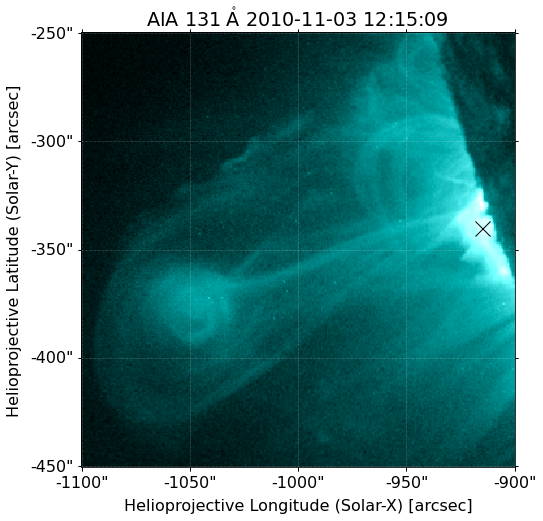

In [6]:
# use Sunpy to help work out pixel location for DEM calculation if know 
# or can just go directly if you already know pixel indices, i.e. m.data[100,100]
px=-915*u.arcsec
py=-340*u.arcsec
data=[]
for m in aprep:
    px_loc=m.world_to_pixel(SkyCoord(px,py, frame=m.coordinate_frame))
    print(px_loc)
    data.append(m.data[int(px_loc[0].value),int(px_loc[1].value)])
data=np.array(data)
print(data)

# Plot where the coords is we are looking at
bottom_left = SkyCoord(-1100*u.arcsec,-450*u.arcsec, frame=aprep[0].coordinate_frame)
top_right = SkyCoord(-900*u.arcsec,-250*u.arcsec, frame=aprep[0].coordinate_frame)
mm = aprep[0].submap(bottom_left, top_right=top_right)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection=mm)
mm.plot()
ax.plot_coord(SkyCoord(px,py, frame=mm.coordinate_frame), 'kx', fillstyle='none', markersize=15)
plt.show()

In [7]:
# Just check things are sorted in the correct order of [94,131,171,193,211,335]
worder=np.argsort(wvn)
durs=durs[worder]
data=data[worder]

In [8]:
# Let's get the degradation correction factors for v8 and v9
channels = [94,131,171,193,211,335] * u.angstrom
time=atime.Time('2010-11-03T12:15:00', scale='utc')
# print(channels)
# print(time.isot)

# nc=len(channels)
# degs=np.empty(nc)
# for i in np.arange(nc):
#       degs[i]=degradation(channels[i],time)
# print(degs)
# for speed just save in here and manually define
degs=np.array([1.14705432, 0.91535957, 0.97148718, 0.98810095, 0.97238522, 0.83229072])

print(degs)


[1.14705432 0.91535957 0.97148718 0.98810095 0.97238522 0.83229072]


In [9]:
# correct for the degradation
cor_data=data/degs

In [10]:
# Now load in the response factors
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_trespv9_en.dat')

# Get rid of the b in the string name (byte vs utf stuff....)
for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
print(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

['A94' 'A131' 'A171' 'A193' 'A211' 'A335']


In [11]:
# Get the data in the correct format for the DEM code, i.e.
# array of data and uncertainty in DN/px/s
dn_in=cor_data/durs
print('dn_in: ',dn_in)

# And the associated uncertainty (no systematics)
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
shotnoise=(dn2ph*cor_data)**0.5/dn2ph
# error in DN/px/s
edn_in=(rdnse**2+shotnoise**2)**0.5/durs
print('edn_in: ',edn_in)
# You might also want to include a systematic uncertainty

dn_in:  [  1.19059593  19.231003   282.85305421 134.20567142  32.9927772
   3.76283793]
edn_in:  [ 0.98227304  3.15137794 12.61130776  8.05587687  3.19016525  0.95541708]


In [12]:
#  What temperature binning do we want for the output DEM?
#  These are the bin edges
#  Need to tweak the range based on what you are looking at
temps=np.logspace(5.6,7.5,num=35)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

Executing in serial
total elapsed time = 0:00:00.008345


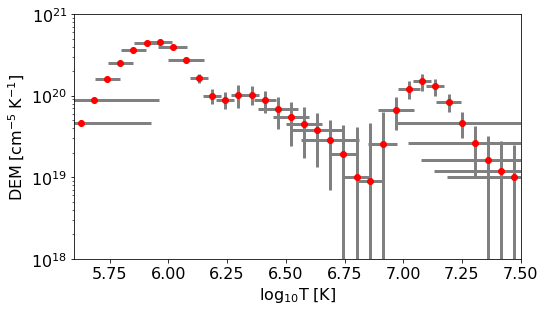

In [13]:
# Work out the DEM
dem,edem,elogt,chisq,dn_reg=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps)

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem,xerr=elogt,yerr=edem,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([1e18,1e21])
plt.xlim([5.6,7.5])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

Executing in serial
total elapsed time = 0:00:00.004063


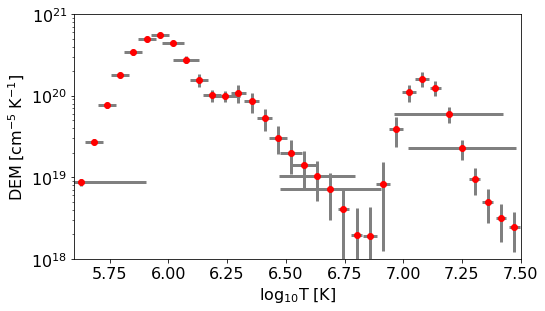

In [14]:
# Now that we have a rough DEM solution could run in again using this to weight the DEM solution
# Original idl version of DEM code did this by default but mapping removed it as slower overall
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,dem_norm0=dem/np.max(dem))

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([1e18,1e21])
plt.xlim([5.6,7.5])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.title('')
plt.savefig('demregpy_aiapxl.png',bbox_inches='tight')
plt.show()